In [1]:
import json, os, sys

from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns

project_dir = os.path.abspath("..")
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)
    
import utils
import result_helper


sns.set(style="whitegrid")

In [2]:
# %load_ext autoreload
# %autoreload 2

In [3]:
data_results_dir = Path("../data/experiments-skadi/")
job_paths = list(data_results_dir.glob("**/job-info.json"))

In [4]:
df_data = result_helper.get_result_summary(job_paths)

In [5]:
cols_irrelavant = [
    "started_at", "completed_at", "precision_score", "recall_score", "f1_score", "random_seed",
    'experiment_type', 'experiment_name', 'component_size', 'variance', 'label_noise_proba',
    'allow_self_loops', 'distance_metric', 'job_path', 'duration_secs'
]
cols_relevant = list(set(df_data.columns) - set(cols_irrelavant))

## Separation vs dimensions/components

Experiment parameters:
- $k = d$ i.e., number of components is the same as the number of dimensions 
- $\beta = k^{1/4}$
- Number of random walk steps: 1
- Number of points in each Gaussian component: 50
- Variance in each component: 1
- No label noise added
- No self-loops


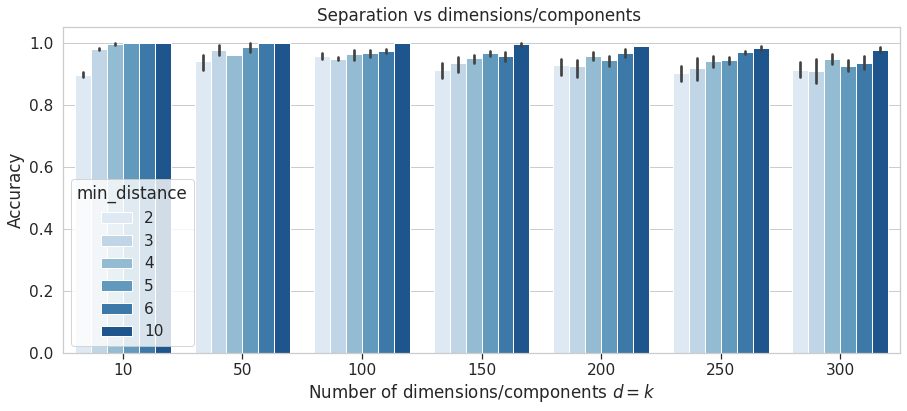

In [6]:
filter_dist_1 = df_data.experiment_name == "dim_dist_01"
filter_dist_2 = df_data.experiment_name == "dim_dist_02"
df_data_filtered = df_data[filter_dist_1 | filter_dist_2].copy()
df_data_filtered = df_data_filtered.sort_values(["min_distance", "n_dim", "bias_factor", "n_steps"])

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(15, 6))
    sns.barplot(
        x="n_dim",y="accuracy_score",hue="min_distance",
        data=df_data_filtered,palette="Blues", ax=ax
    )
    ax.yaxis.grid(True)
    ax.yaxis.set_minor_locator(ticker.LinearLocator(numticks=10))
    ax.tick_params(which="both", bottom=True)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Number of dimensions/components $d=k$")
    ax.set_title(f"Separation vs dimensions/components ");
    # ax.set_ylim([0, 1])

## Number of random walk steps

Experiment parameters:
- $k = d$ i.e., number of components is the same as the number of dimensions 
- $\beta = k^{1/4}$
- Separation: 2 or 3
- Number of points in each Gaussian component: 50
- Variance in each component: 1
- No label noise added
- No self-loops


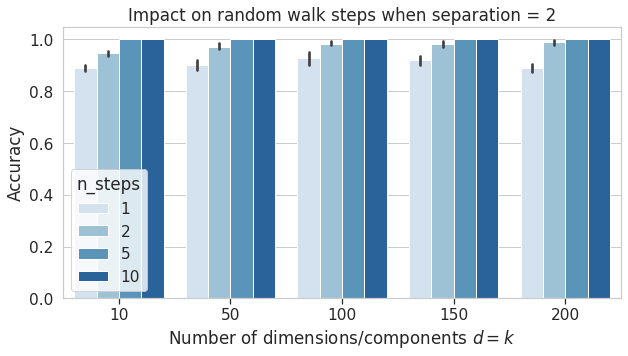

In [7]:
filter_steps_01 = df_data.experiment_name == "dim_steps_01"
df_data_filtered = df_data[filter_steps_01].copy()
df_data_filtered = df_data_filtered.sort_values(["min_distance", "n_dim", "bias_factor", "n_steps"])

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(
        x="n_dim",y="accuracy_score", hue="n_steps",
        data=df_data_filtered,palette="Blues", ax=ax
    )
    ax.yaxis.grid(True)
    ax.yaxis.set_minor_locator(ticker.LinearLocator(numticks=10))
    ax.tick_params(which="both", bottom=True)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Number of dimensions/components $d=k$")
    ax.set_title(f"Impact on random walk steps when separation = 2");
    # ax.set_ylim([0, 1])

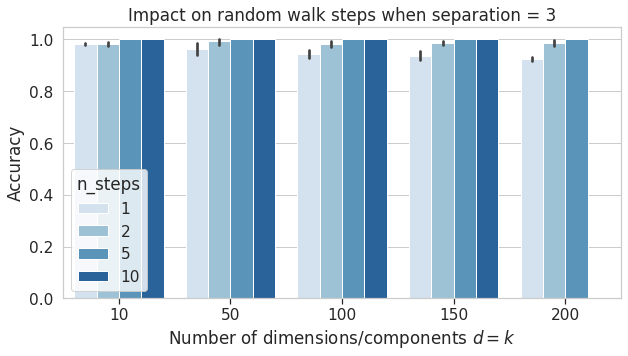

In [8]:
filter_steps_01 = df_data.experiment_name == "dim_steps_02"
df_data_filtered = df_data[filter_steps_01].copy()
df_data_filtered = df_data_filtered.sort_values(["min_distance", "n_dim", "bias_factor", "n_steps"])

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(
        x="n_dim",y="accuracy_score", hue="n_steps",
        data=df_data_filtered,palette="Blues", ax=ax
    )
    ax.yaxis.grid(True)
    ax.yaxis.set_minor_locator(ticker.LinearLocator(numticks=10))
    ax.tick_params(which="both", bottom=True)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Number of dimensions/components $d=k$")
    ax.set_title(f"Impact on random walk steps when separation = 3");
    # ax.set_ylim([0, 1])